In [1]:
# Imports
from fastquant import get_stock_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Using TensorFlow backend.


In [2]:
# Parameters for fastquant
train_start_date = "2006-01-01"
train_end_date = "2016-12-31"
test_start_date = "2017-01-01"
test_end_date = "2017-12-31"
ticker = "IBM"
inputs = ['open','high','low','close','volume']

# Parameters for data 
previous_days = 60 # Previous day worth of data to train on

# Hyperparameters
hp_optimizer='rmsprop'
hp_loss='mean_squared_error'
hp_epochs=25
hp_batch_size=250

# Scaler
mmc = MinMaxScaler(feature_range=(0,1))
stdc = StandardScaler()

train_data = []
test_data = []
def load_data(in_inputs):
    train_data = get_stock_data(ticker, train_start_date, train_end_date)[in_inputs].values
    test_data = get_stock_data(ticker, test_start_date, test_end_date)[in_inputs].values

    train_data = train_data.reshape(-1, 1)
    test_data = test_data.reshape(-1, 1)

    return train_data, test_data

def get_train_test_data(train_data, test_data, scaler):
    train_scale = scaler.fit_transform(train_data)
    test_scale = scaler.transform(test_data)

    X_train = []
    Y_train = []

    for i in range(previous_days, len(train_scale)):
        X_train.append(train_scale[i-previous_days:i,0])
        Y_train.append(train_scale[i,0])

    x_train,y_train = np.array(X_train),np.array(Y_train)

    x_train = np.reshape(x_train, (*x_train.shape,1))

    X_test = []
    for i in range(previous_days,len(test_scale)):
        X_test.append(test_scale[i-previous_days:i,0])

    x_test = np.array(X_test)
    x_test = np.reshape(x_test, (*x_test.shape,1))

    return x_train, y_train, x_test

In [3]:
# Train/Gen model
def gen_model(x_train,y_train,x_test,inepoch,inbatch_size,scaler,optimizer_func,loss_func):

    # Our simple RNN as an example    
    model = Sequential()
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32))
    model.add(Dense(1))

    model.compile(optimizer=optimizer_func,loss=loss_func)

    model.fit(x_train,y_train,epochs=inepoch,batch_size=inbatch_size)

    scaled_preds = model.predict(x_test)
    test_preds = scaler.inverse_transform(scaled_preds)

    return model, test_preds

In [4]:
# Predict 
preds = []
for i in range(len(inputs)):
    print(inputs[:i+1])

    train_data, test_data = load_data(inputs[:i+1])

    x_train, y_train, x_test = get_train_test_data(train_data, test_data, mmc)

    model, pred = gen_model(x_train,y_train,x_test,hp_epochs,hp_batch_size,mmc,hp_optimizer,hp_loss)

    preds.append(pred)


['open']
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Epoch 1/25
2709/2709 [==============================] - 1s 491us/step - loss: 0.1724
Epoch 2/25
2709/2709 [==============================] - 1s 261us/step - loss: 0.0503
Epoch 3/25
2709/2709 [==============================] - 1s 258us/step - loss: 0.0422
Epoch 4/25
2709/2709 [==============================] - 1s 257us/step - loss: 0.0350
Epoch 5/25
2709/2709 [==============================] - 1s 259us/step - loss: 0.0292
Epoch 6/25
2709/2709 [==============================] - 1s 258us/step - loss: 0.0270
Epoch 7/25
2709/2709 [==============================] - 1s 261us/step - loss: 0.0235
Epoch 8/25
2709/2709 [==============================] - 1s 257us/step - loss: 0.0230
Epoch 9/25
2709/2709 [==============================] - 1s 255us/step - loss: 0.0253
Epoch 10/25
2709/2709 [==============================] - 1s 256us/step - loss: 0.0109
Ep

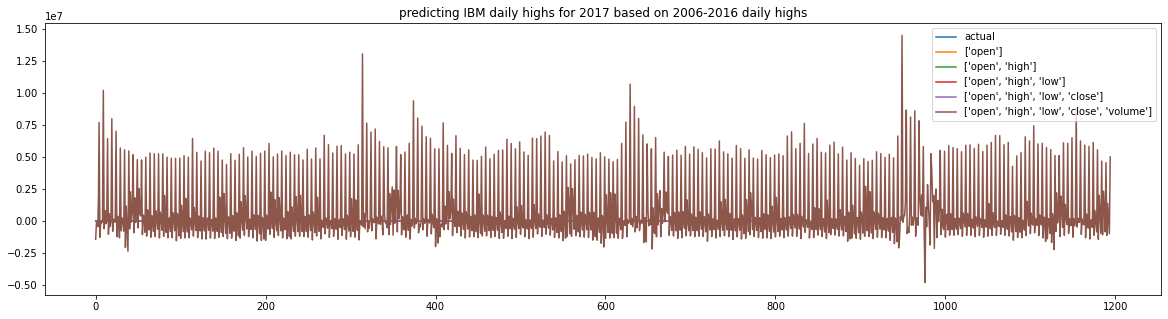

In [10]:
# Plot

diff = len(test_data) - len(preds)
plt.figure(figsize=(20,5))
plt.plot(test_data[diff:], label='actual')

for i in range(len(preds)):
    label = inputs[:i+1]
    plt.plot(preds[i], label=label)

plt.title(f'predicting IBM daily highs for 2017 based on 2006-2016 daily highs')
plt.legend()
plt.savefig('../imgs/graph1.png')
plt.show()